# Predict survival using logistic regression with sex, age and title

**Author:** [Filippo Bovo](https://github.com/FilippoBovo) ([filippo@satalia.com](mailto:filippo@satalia.com))

**Achievement:** Using the sex, age and title of passengers, we fit a ridge logistic regression model that predicts if a passenger will survive with about 78.2% accurancy, improving by 16.7% over the 61.5% accuracy of the majority classifier.

## Introduction

In this notebook, we will go over some typical steps of a data science pipeline in order to predict if a passenger survives the Titanic accident:
- Data loading
- Data cleaning
- Feature engineering
- Predictions
    - Majority classifier (benchmark)
    - Ridge logistic regression

Part of this analysis is inspired by the blog article [How to score 0.8134 in Titanic Kaggle Challenge](http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html).

Note that we are not aiming to achieve a high score, but just to show a data science workflow.

In [1]:
%load_ext watermark
%watermark

2020-07-10T16:41:23-06:00

CPython 3.7.4
IPython 7.8.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores  : 8
interpreter: 64bit


> Adding the above watermark makes it easer to check for compatibility or reproducibility issues.

In [28]:
# Import libraries
# ----------------

# System
import sys

# Logging
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO, stream=sys.stdout)

# Pandas
import pandas as pd

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#from titanic import data, models; had to revise this code to the following to load these modules; and add dir to sys_path
from data import extract_title 
from models import data_preparation, run_majority_vote, run_logistic_regression

In [26]:
print(sys.path)

['C:\\Users\\lelli\\Python\\production-data-science\\tutorial\\a-setup\\exploration\\predict_survival_using_logistic_regression_with_sex_age_title', 'C:\\Users\\lelli\\Anaconda3\\python37.zip', 'C:\\Users\\lelli\\Anaconda3\\DLLs', 'C:\\Users\\lelli\\Anaconda3\\lib', 'C:\\Users\\lelli\\Anaconda3', '', 'C:\\Users\\lelli\\Anaconda3\\lib\\site-packages', 'C:\\Users\\lelli\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\lelli\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\lelli\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\lelli\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\lelli\\.ipython', 'C:\\Users\\lelli\\Python\\production-data-science\\tutorial\\a-setup\\titanic', 'C:\\Users\\lelli\\Python\\production-data-science\\tutorial\\a-setup\\titanic', 'C:\\Users\\lelli\\appdata\\local\\programs\\python\\python37\\lib\\site-packages']


In [25]:
sys.path.append('C:\\Users\\lelli\\Python\\production-data-science\\tutorial\\a-setup\\titanic')
sys.path.append("C:\\Users\\lelli\\appdata\\local\\programs\\python\\python37\\lib\\site-packages")

> <span style="color:orange">REFACTORED Here we loaded the logging module to display the messages from the code refactored into the `data.py` and `models.py` modules.</span>

## Data Loading

In this section, we load the `titanic.csv` data.

In [16]:
raw_data_file = "../data/titanic.csv"
df = pd.read_csv(raw_data_file, usecols=['Name', 'Sex', 'Age', 'Survived'])
print('DataFrame shape: {}'.format(df.shape))
df.head()

DataFrame shape: (891, 4)


,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


A description of the column names can be found in the [Kaggle challenge page](https://www.kaggle.com/c/titanic/data).

> Always store file and directory names into variables and use the `os.path` functions to manipulate paths. In this case, `raw_data_file = "../data/titanic.csv"`.

## Data Cleaning

The percentage of missing values in the whole dataset in each column is:

In [17]:
# Percentage of missing values in each column
pd.DataFrame(
    df.isnull().sum() / len(df),
    columns=['% Missing Values']
).transpose()

,Survived,Name,Sex,Age
% Missing Values,0.0,0.0,0.0,0.198653


About a fifth of the passenger ages is missing. We may substitute the missing values with the age mean or median. To understand which one to choose, let us have a look at the histogram of the passenger age,

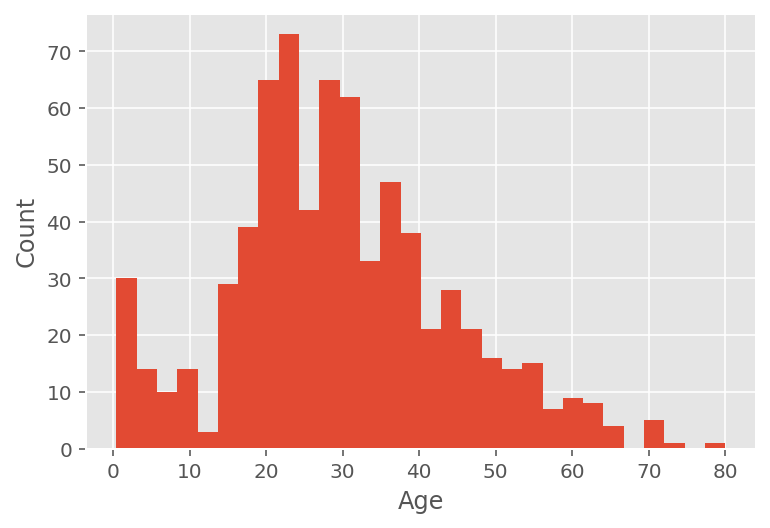

In [18]:
# Age histogram
df.Age.hist(bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Because the age has a tail for higher values, we choose the median to replace missing values, as the median is more robust than the mean against extreme values.

In [19]:
df = df.fillna({'Age': df.Age.median(), })
df.head()

,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


Now that we don't have any missing values, we can assign a variable type to each column.

In [20]:
df = df.astype({
    'Age': 'float64',
    'Name': 'object',
    'Sex': 'category',
    'Survived': 'int64',
})

## <span style="color:orange">REFACTORED</span> Feature Engineering

The passenger names contain titles which we can use to make predictions under the assumption that more wealthy people we have been given precedence to the emergency boats. However, some of the 18 titles in the data are redundant and can be reduced to 6.

In [30]:
df = extract_title(df)
df.head()

Extracting the titles from the name column


,Survived,Name,Sex,Age,Title
0,0,"Braund, Mr. Owen Harris",male,22.0,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,Mrs
2,1,"Heikkinen, Miss. Laina",female,26.0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,Mrs
4,0,"Allen, Mr. William Henry",male,35.0,Mr


> <span style="color:orange">Note how the logging module is used in the noteboook just for printing normal messages from modules.</span>

## <span style="color:orange">REFACTORED</span> Predictions

Having completed the data preprocessing, we prepare the data to run models.

In [31]:
X_train, X_test, y_train, y_test = data_preparation(df, test_size=0.2, random_state=0)

Splitting the data-frame into train and test parts


First, we start by defining a simple benchmark over which we can improve with a more elaborate model. For the benchmark, we use the majority vote classifier.

In [32]:
run_majority_vote(X_train, X_test, y_train, y_test);

Running the majority vote classifier
The prediction accuracy with the majority vote classifier is 61.5%


Next, we use a ridge logistic regression.

In [33]:
run_logistic_regression(X_train, X_test, y_train, y_test);

Running the ridge logistic regression classifier
The prediction accuracy with the ridge logistic regression classifier is 78.2%


In conclusion, using the sex, age and title of passengers, we fited a ridge logistic regression model that, for our particular train-test split, predicts if a passenger will survive with about 78.2% accurancy, improving by 16\.7% over the 61.5% accuracy of the majority classifier.

<span style="color:orange">In this notebook we refactored the code by transfering part of it into the `data.py` and `models.py` modules.</span>

> <span style="color:orange">Note that, as a consequence of refactoring, the notebook contains less code and, therefore, it is easier to follow the analysis.</span>
